# Lifting Tracker
Sync workout JSON files, compute metrics, and visualize progress toward fitness goals.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import glob
import os
from datetime import datetime

# === PLOT STYLING ===
plt.rcParams.update({
    # Font sizes
    "axes.labelsize": 14,
    "axes.titlesize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 11,
    "figure.titlesize": 18,
    # Bold fonts
    "axes.labelweight": "bold",
    "axes.titleweight": "bold",
    # Thicker spines
    "axes.linewidth": 2,
    "xtick.major.width": 1.5,
    "ytick.major.width": 1.5,
    "xtick.major.size": 6,
    "ytick.major.size": 6,
    # Grid
    "axes.grid": True,
    "grid.alpha": 0.3,
})
sns.set_style("whitegrid")

DATA_DIR = "../data/"
EXCEL_FILE = "workout_log.xlsx"

In [2]:
# Movement Family Mapping
FAMILY_MAP = {
    # Squat
    "Front Squat": "Squat", "Back Squat": "Squat", "Zercher Squat": "Squat",
    # Hinge
    "Deadlift": "Hinge", "Zercher Deadlift": "Hinge", "Romanian Deadlift": "Hinge",
    "RDL": "Hinge", "Kettlebell Swings": "Hinge",
    # Horizontal Push
    "Barbell Bench Press": "Push (H)", "Incline BB Press": "Push (H)", "DB Press": "Push (H)",
    "Incline DB Press": "Push (H)", "Incline DB Fly": "Push (H)", "Dips": "Push (H)",
    "Dumbbell Pullover": "Push (H)",
    # Vertical Push
    "Standing OHP": "Push (V)", "Overhead Press": "Push (V)", "DB Shoulder Press": "Push (V)",
    "Standing Overhead Press": "Push (V)",
    # Horizontal Pull
    "Bent over Barbell Rows": "Pull (H)", "Bent over barbell row": "Pull (H)", "Cable Rows": "Pull (H)",
    # Vertical Pull
    "Pull Ups": "Pull (V)", "Lat Pulldown": "Pull (V)",
    # Isolation
    "Incline Bicep Curl": "Isolation", "Barbell Bicep Curl": "Isolation",
    "Cable Bicep Curl": "Isolation", "Cable Tricep Pushdown": "Isolation",
    # Core
    "Cable Crunches": "Core"
}

# 2026 Strength Milestones: (weight_kg, reps)
# Keys are search terms (case-insensitive partial match against Movement)
MILESTONES = {
    "Squat": [(100, 20), (140, 5)],
    "Deadlift": [(200, 1), (140, 8)],
    "Overhead Press": [(60, 3), (40, 12)],
    "Bench Press": [(100, 2), (60, 10)],
    "barbell row": [(80, 6), (60, 12)],
    "Kettlebell": [(24, 80)]
}

MOVEMENT_PATTERNS = ["Squat", "Hinge", "Push (H)", "Push (V)", "Pull (H)", "Pull (V)"]

In [3]:
def sync_json_to_excel(data_dir=DATA_DIR, excel_filename=EXCEL_FILE):
    """Sync workout JSON files to Excel log, deduplicating by timestamp."""
    excel_path = os.path.join(data_dir, excel_filename)
    
    # Load existing data
    existing_timestamps = set()
    if os.path.exists(excel_path):
        df_existing = pd.read_excel(excel_path)
        if not df_existing.empty:
            existing_timestamps = set(df_existing["Timestamp"].astype(str).str.strip().unique())
            print(f"Loaded {len(existing_timestamps)} existing sessions from Excel.")
    else:
        print("Excel log not found. Starting fresh.")
        df_existing = pd.DataFrame()

    # Find and process JSON files
    new_records = []
    json_files = glob.glob(os.path.join(data_dir, "*.json"))
    print(f"Found {len(json_files)} JSON files in {data_dir}.")

    for file in json_files:
        # Extract timestamp from filename (YYYYMMDD_HHMMSS.json)
        basename = os.path.splitext(os.path.basename(file))[0]
        try:
            file_ts = datetime.strptime(basename, "%Y%m%d_%H%M%S")
            file_ts_str = file_ts.strftime("%Y-%m-%d %H:%M:%S")
        except ValueError:
            file_ts_str = None
        
        with open(file, "r") as f:
            try:
                session_data = json.load(f)
            except json.JSONDecodeError:
                print(f"Error: Could not decode {file}. Skipping.")
                continue
        
        if not session_data:
            continue
            
        # Use file timestamp if record timestamp is missing/None
        session_ts = str(session_data[0].get("Timestamp") or file_ts_str).strip()
        
        if session_ts not in existing_timestamps and session_ts != "None":
            # Apply file timestamp to records missing timestamps
            for record in session_data:
                if not record.get("Timestamp") and file_ts_str:
                    record["Timestamp"] = file_ts_str
            new_records.extend(session_data)
            existing_timestamps.add(session_ts)
            print(f"Adding session: {session_ts}")
        else:
            print(f"Skipping: {session_ts}")

    # Append and save
    if new_records:
        df_new = pd.DataFrame(new_records)
        if "Load_kg" in df_new.columns and "Reps" in df_new.columns:
            df_new["e1RM"] = df_new["Load_kg"] * (1 + df_new["Reps"] / 30)
        
        df_final = pd.concat([df_existing, df_new], ignore_index=True)
        cols = ["Timestamp"] + [c for c in df_final.columns if c != "Timestamp"]
        df_final = df_final[cols]
        df_final.to_excel(excel_path, index=False)
        print(f"SUCCESS: {len(new_records)} sets written.")
    else:
        print("No new data to sync.")

sync_json_to_excel()

Loaded 6 existing sessions from Excel.
Found 6 JSON files in ../data/.
Skipping: 2026-01-25 10:00:00
Skipping: 2026-01-26 21:38:00
Skipping: 2026-01-27 21:00:00
Skipping: 2026-01-29 18:00:00
Skipping: 2026-01-31 21:00:00
Adding session: 2026-02-01 18:00:00
SUCCESS: 23 sets written.


In [4]:
def load_and_prepare_data(data_dir=DATA_DIR, excel_filename=EXCEL_FILE):
    """Load Excel data and apply derived columns."""
    excel_path = os.path.join(data_dir, excel_filename)
    df = pd.read_excel(excel_path)
    
    # Ensure Timestamp is datetime
    df["Timestamp"] = pd.to_datetime(df["Timestamp"])
    df["Date"] = df["Timestamp"].dt.date
    
    # Calculate derived metrics
    df["Family"] = df["Movement"].map(FAMILY_MAP).fillna("Other")
    df["e1RM"] = df["Load_kg"] * (1 + df["Reps"] / 30)
    
    if "Volume_Load" not in df.columns:
        df["Volume_Load"] = df["Load_kg"] * df["Reps"]
    
    return df

df = load_and_prepare_data()
latest_date = df["Date"].max()
latest_session = df[df["Date"] == latest_date]

print(f"Loaded {len(df)} sets across {df['Date'].nunique()} sessions.")
print(f"Latest session: {latest_date}")

Loaded 157 sets across 6 sessions.
Latest session: 2026-02-01


## Session Tonnage Over Time

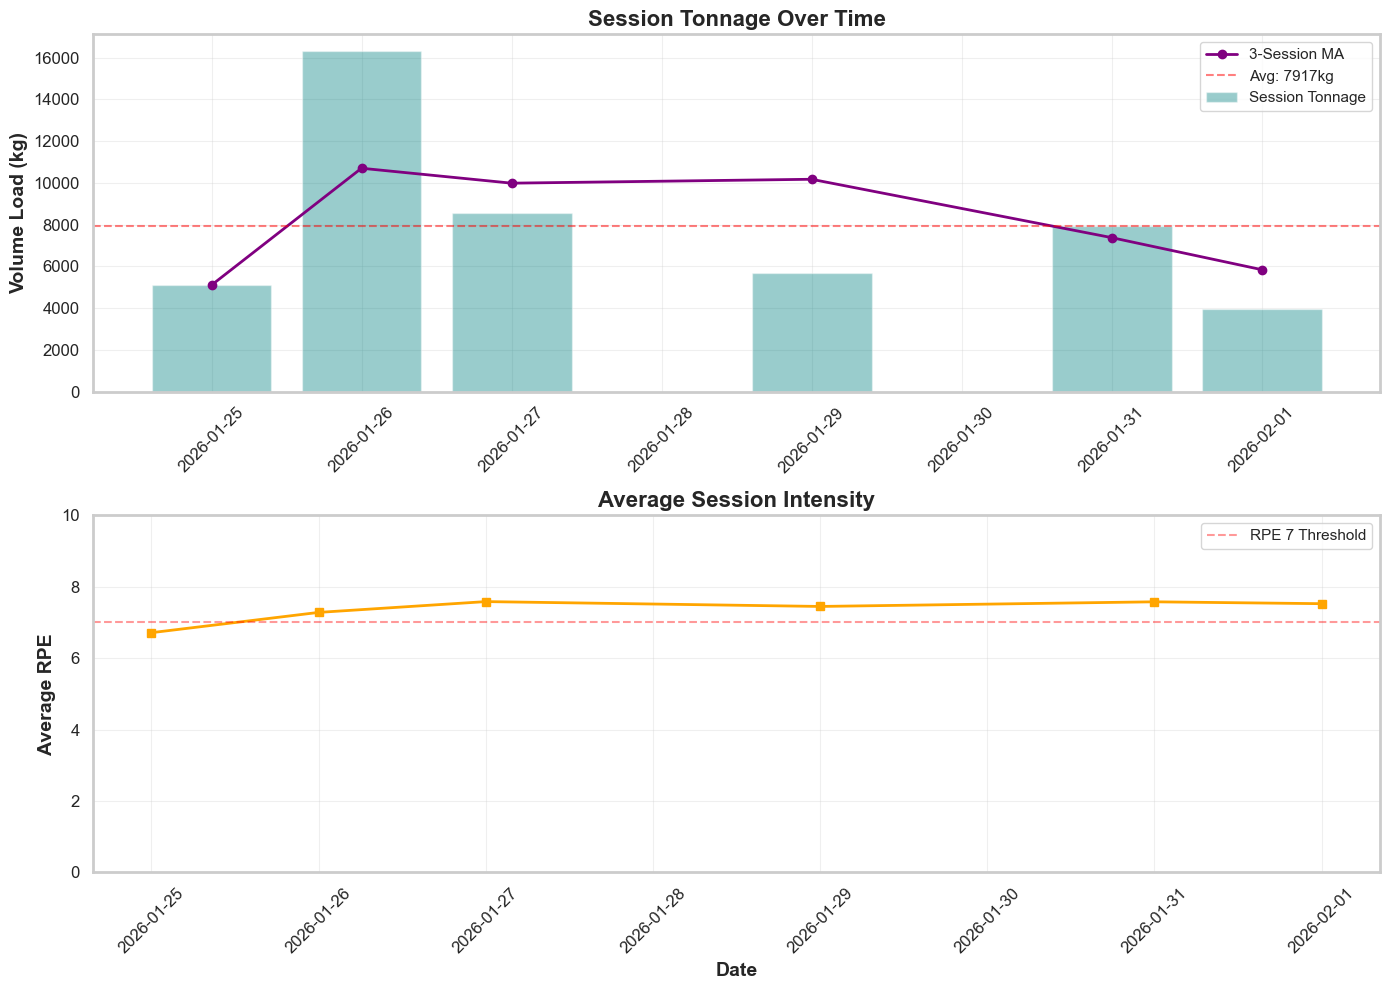

In [5]:
session_stats = df.groupby("Date").agg({
    "Volume_Load": "sum",
    "Intensity_RPE": "mean",
    "Movement": "count"
}).rename(columns={"Movement": "Set_Count"}).reset_index()

session_stats["MA_3"] = session_stats["Volume_Load"].rolling(window=3, min_periods=1).mean()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Volume over time
ax1.bar(session_stats["Date"], session_stats["Volume_Load"], alpha=0.4, color="teal", label="Session Tonnage")
ax1.plot(session_stats["Date"], session_stats["MA_3"], color="purple", linewidth=2, marker="o", label="3-Session MA")
avg_tonnage = session_stats["Volume_Load"].mean()
ax1.axhline(y=avg_tonnage, color="red", linestyle="--", alpha=0.5, label=f"Avg: {avg_tonnage:.0f}kg")
ax1.set_ylabel("Volume Load (kg)")
ax1.set_title("Session Tonnage Over Time")
ax1.legend()
ax1.tick_params(axis="x", rotation=45)

# RPE over time
ax2.plot(session_stats["Date"], session_stats["Intensity_RPE"], marker="s", color="orange", linewidth=2)
ax2.axhline(y=7, color="red", linestyle="--", alpha=0.4, label="RPE 7 Threshold")
ax2.set_ylabel("Average RPE")
ax2.set_xlabel("Date")
ax2.set_ylim(0, 10)
ax2.set_title("Average Session Intensity")
ax2.legend()
ax2.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

## Latest Session Analysis

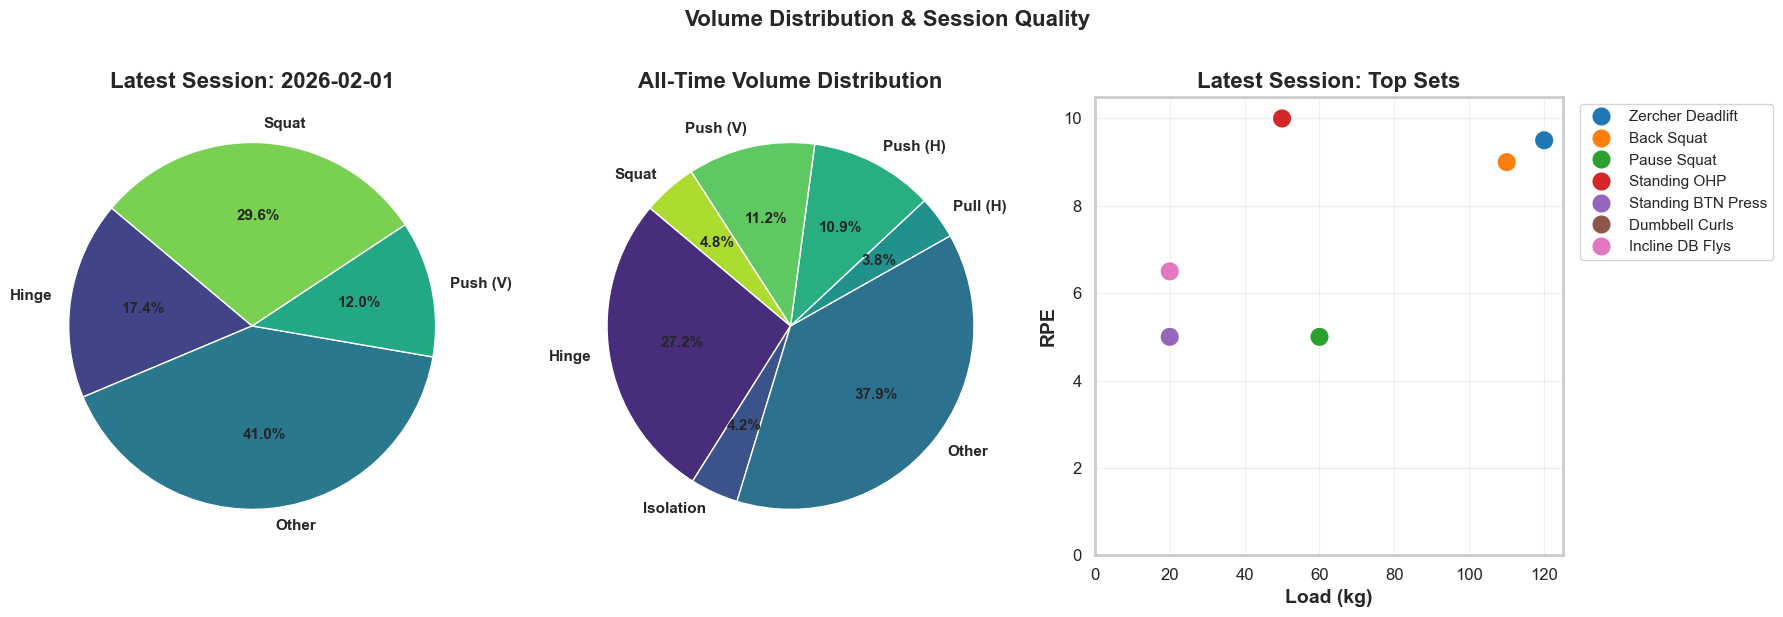

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Volume distribution - Latest Session
family_dist = latest_session.groupby("Family")["Volume_Load"].sum()
axes[0].pie(family_dist, labels=family_dist.index, autopct="%1.1f%%", startangle=140,
            colors=sns.color_palette("viridis", len(family_dist)), 
            textprops={"fontsize": 11, "fontweight": "bold"})
axes[0].set_title(f"Latest Session: {latest_date}")

# 2. Volume distribution - All Time
total_dist = df.groupby("Family")["Volume_Load"].sum()
axes[1].pie(total_dist, labels=total_dist.index, autopct="%1.1f%%", startangle=140,
            colors=sns.color_palette("viridis", len(total_dist)),
            textprops={"fontsize": 11, "fontweight": "bold"})
axes[1].set_title("All-Time Volume Distribution")

# 3. Top sets: Load vs RPE (latest session)
top_sets = latest_session.sort_values("Load_kg", ascending=False).drop_duplicates("Movement")
sns.scatterplot(data=top_sets, x="Load_kg", y="Intensity_RPE", hue="Movement", s=200, ax=axes[2])
axes[2].set_title("Latest Session: Top Sets")
axes[2].set_xlabel("Load (kg)")
axes[2].set_ylabel("RPE")
axes[2].set_xlim(left=0)
axes[2].set_ylim(0, 10.5)
axes[2].legend(bbox_to_anchor=(1.02, 1), loc="upper left")

plt.suptitle("Volume Distribution & Session Quality", fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

## Strength Matrix (Current e1RM)

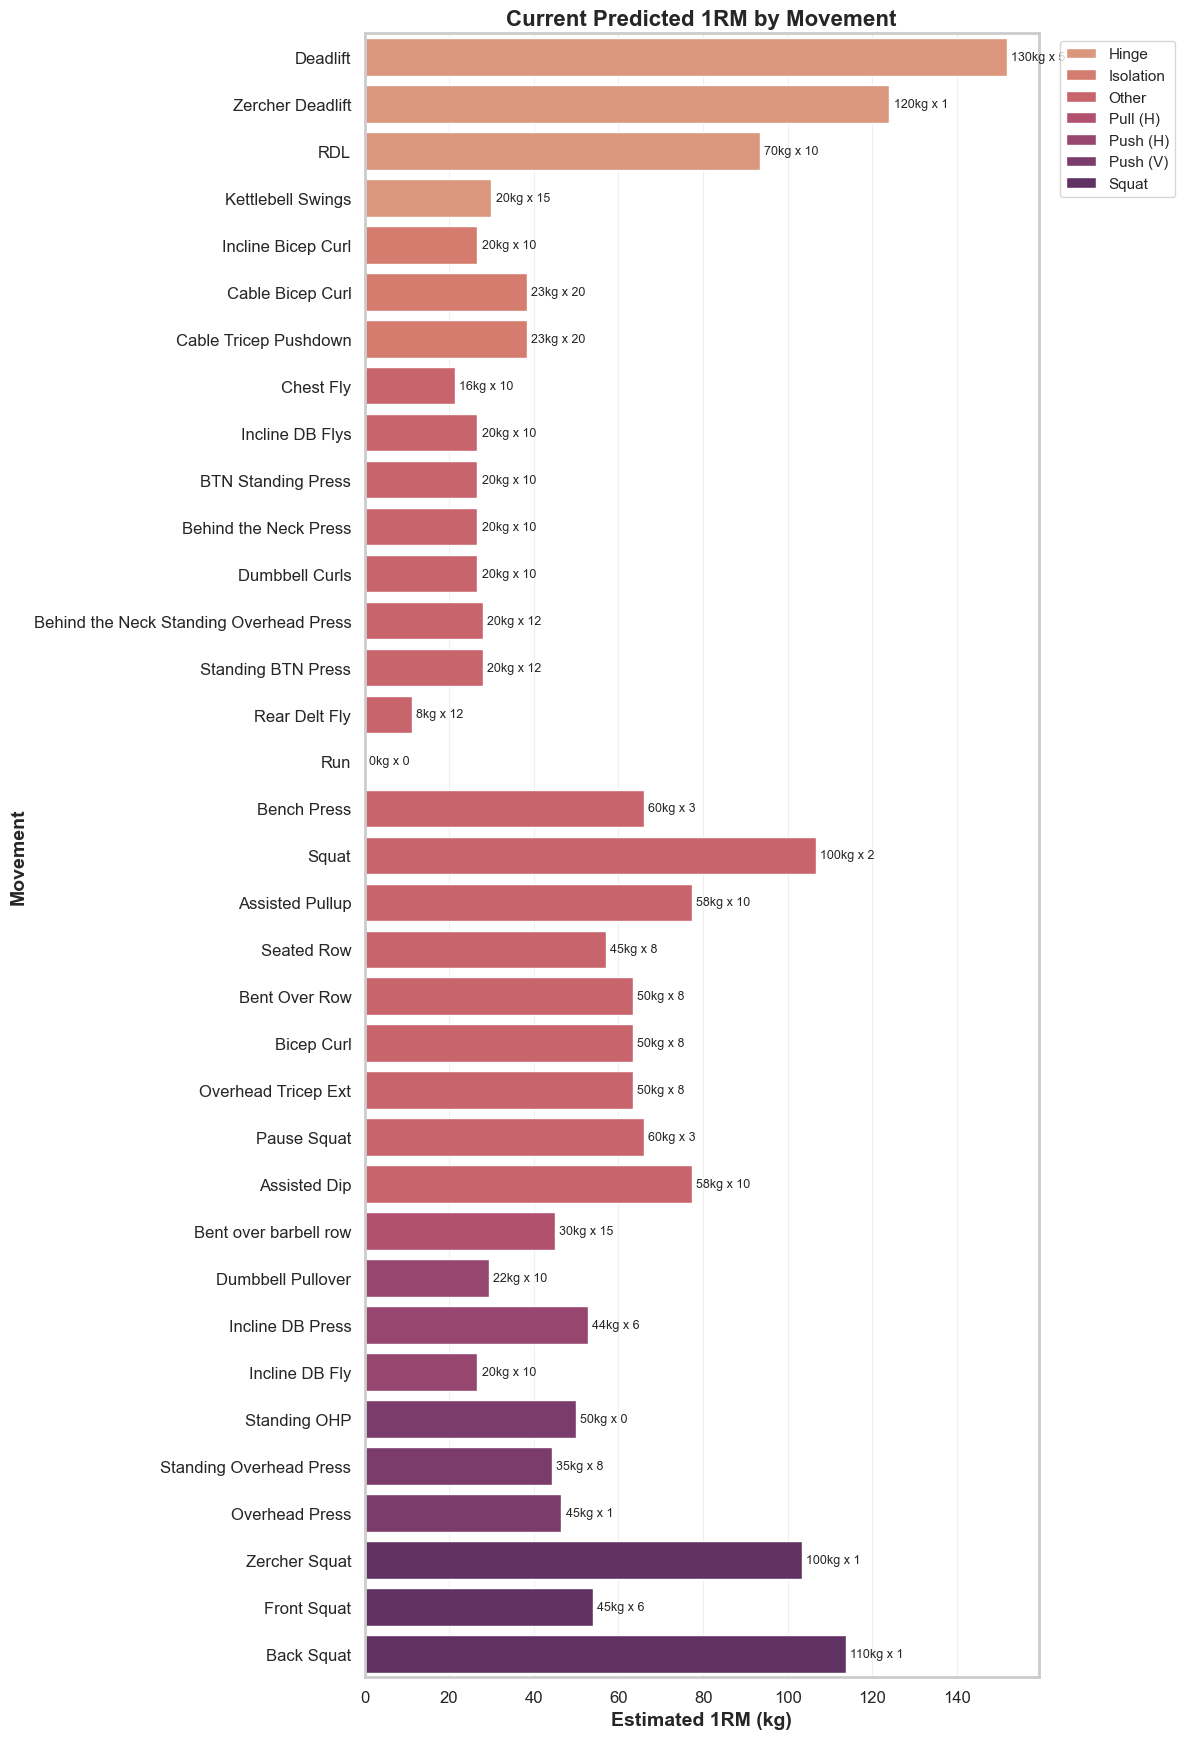

In [7]:
# Get best e1RM for each movement
max_perf = df.sort_values("e1RM", ascending=False).drop_duplicates("Movement")
matrix_data = max_perf[["Movement", "Family", "e1RM", "Load_kg", "Reps"]].sort_values("Family")

plt.figure(figsize=(12, len(matrix_data) * 0.5))
sns.barplot(data=matrix_data, x="e1RM", y="Movement", hue="Family", dodge=False, palette="flare")

for i, row in enumerate(matrix_data.itertuples()):
    plt.text(row.e1RM + 1, i, f"{row.Load_kg}kg x {row.Reps}", va="center", fontsize=9)

plt.title("Current Predicted 1RM by Movement")
plt.xlabel("Estimated 1RM (kg)")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

## e1RM Progression Over Time

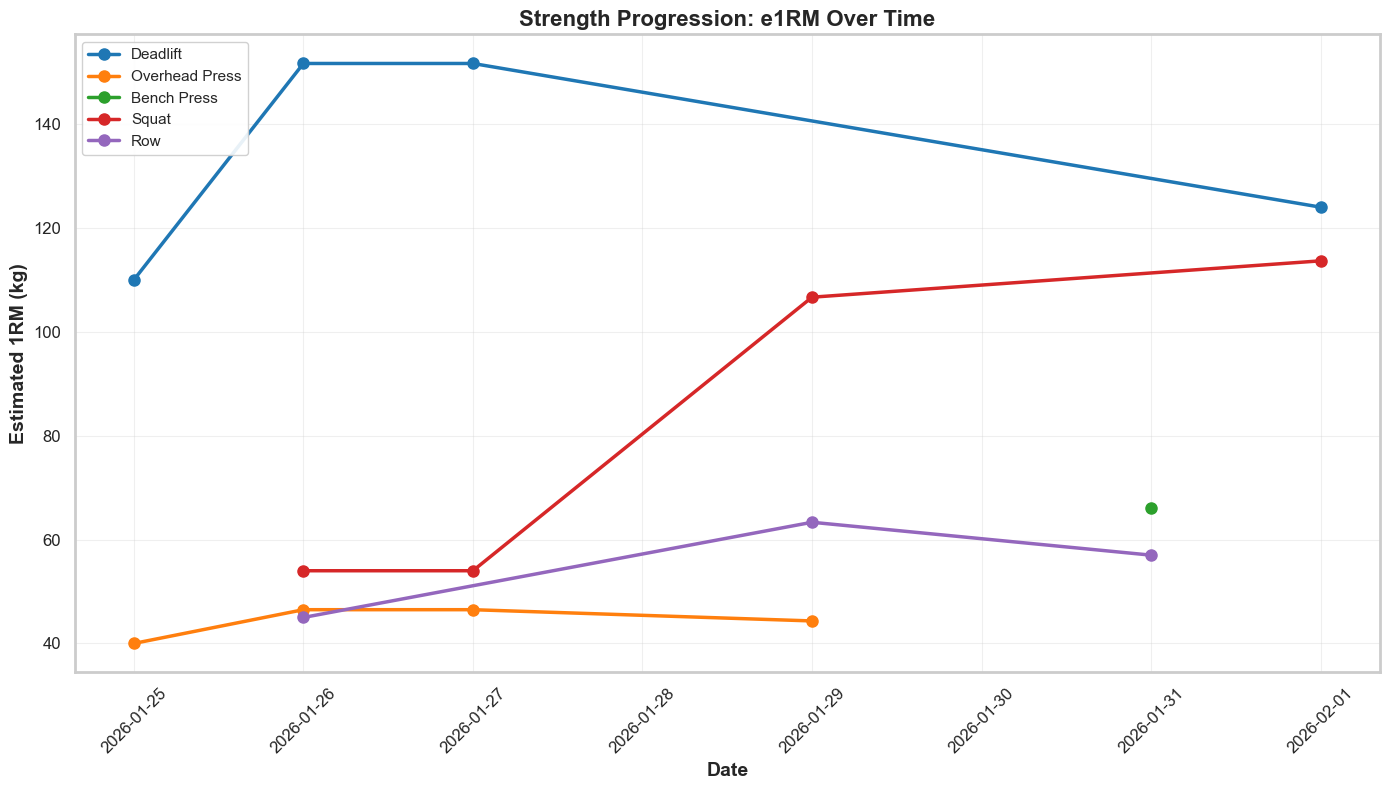

In [8]:
# Track e1RM progression for key compound movements
key_movements = ["Deadlift", "Overhead Press", "Bench Press", "Squat", "Row"]

fig, ax = plt.subplots(figsize=(14, 8))

for move in key_movements:
    move_df = df[df["Movement"].str.contains(move, case=False, na=False)].copy()
    if not move_df.empty:
        # Get best e1RM per session
        best_per_session = move_df.groupby("Date")["e1RM"].max().reset_index()
        ax.plot(best_per_session["Date"], best_per_session["e1RM"], 
                marker="o", linewidth=2.5, markersize=8, label=move)

ax.set_xlabel("Date")
ax.set_ylabel("Estimated 1RM (kg)")
ax.set_title("Strength Progression: e1RM Over Time")
ax.legend(loc="upper left", framealpha=0.9)
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

## Movement Pattern Balance

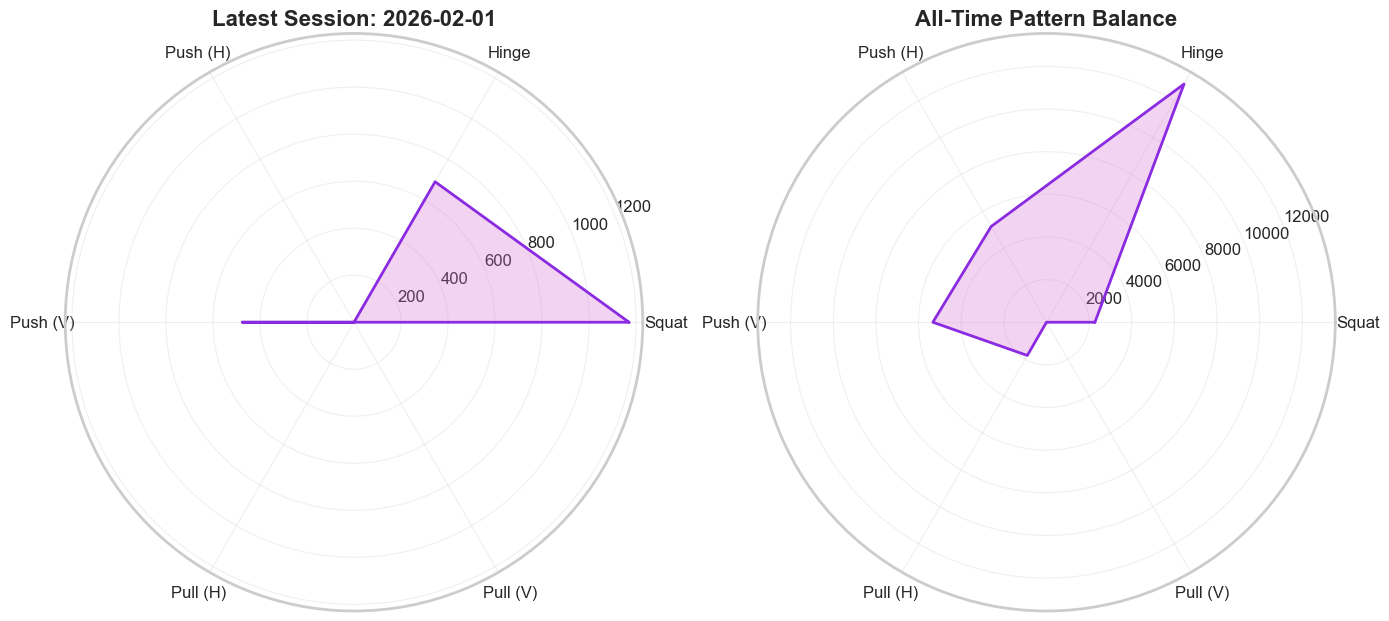

In [9]:
def plot_radar(stats, title, ax):
    """Plot radar chart for movement pattern balance."""
    values = stats.reindex(MOVEMENT_PATTERNS, fill_value=0).values.flatten().tolist()
    values += values[:1]  # Close polygon
    angles = [n / len(MOVEMENT_PATTERNS) * 2 * np.pi for n in range(len(MOVEMENT_PATTERNS))]
    angles += angles[:1]
    
    ax.plot(angles, values, color="#8a2be2", linewidth=2)
    ax.fill(angles, values, color="#da70d6", alpha=0.3)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(MOVEMENT_PATTERNS)
    ax.set_title(title)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7), subplot_kw=dict(polar=True))

# Latest session balance
session_vol = latest_session.groupby("Family")["Volume_Load"].sum()
plot_radar(session_vol, f"Latest Session: {latest_date}", ax1)

# All-time balance
total_vol = df.groupby("Family")["Volume_Load"].sum()
plot_radar(total_vol, "All-Time Pattern Balance", ax2)

plt.tight_layout()
plt.show()

## Volume Composition Over Time

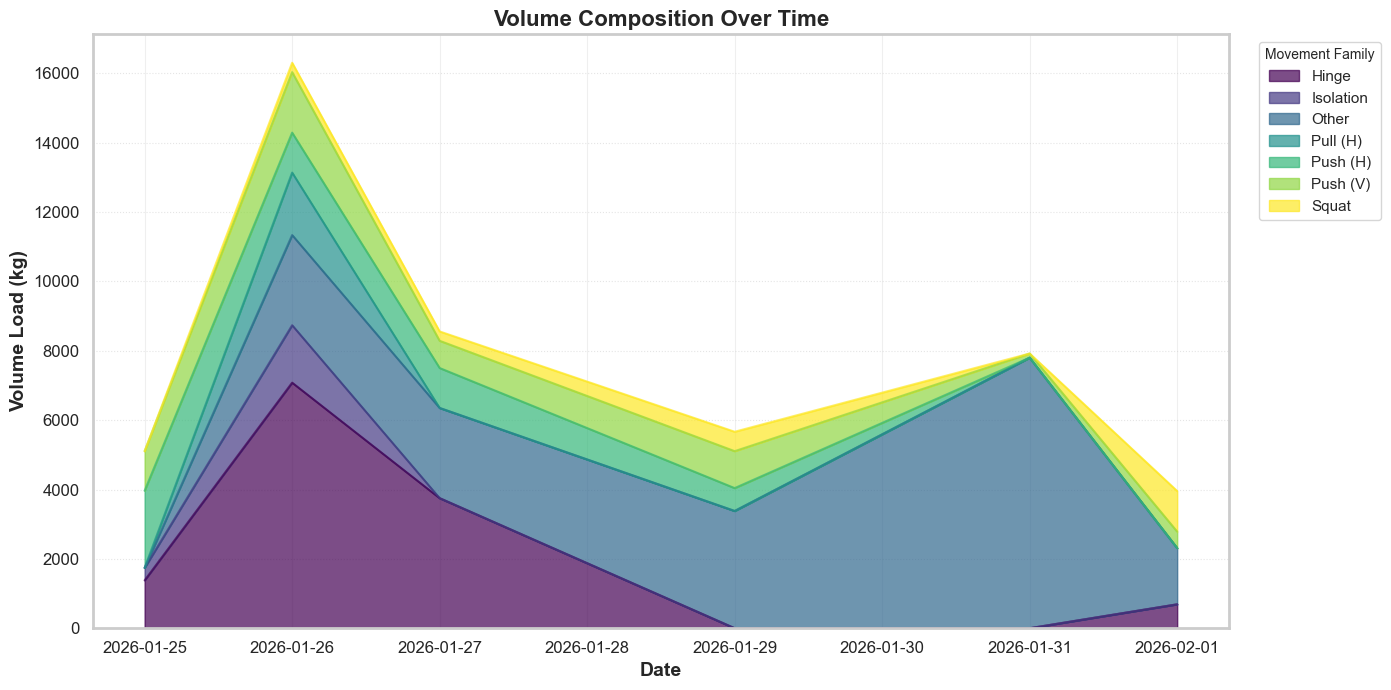

In [10]:
# Stacked area chart by family
pivot_df = df.pivot_table(index="Date", columns="Family", values="Volume_Load", aggfunc="sum").fillna(0)

plt.figure(figsize=(14, 7))
pivot_df.plot(kind="area", stacked=True, ax=plt.gca(), colormap="viridis", alpha=0.7)

plt.title("Volume Composition Over Time")
plt.ylabel("Volume Load (kg)")
plt.xlabel("Date")
plt.legend(title="Movement Family", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(axis="y", linestyle=":", alpha=0.5)
plt.tight_layout()
plt.show()

## Set Quality & Training Intensity

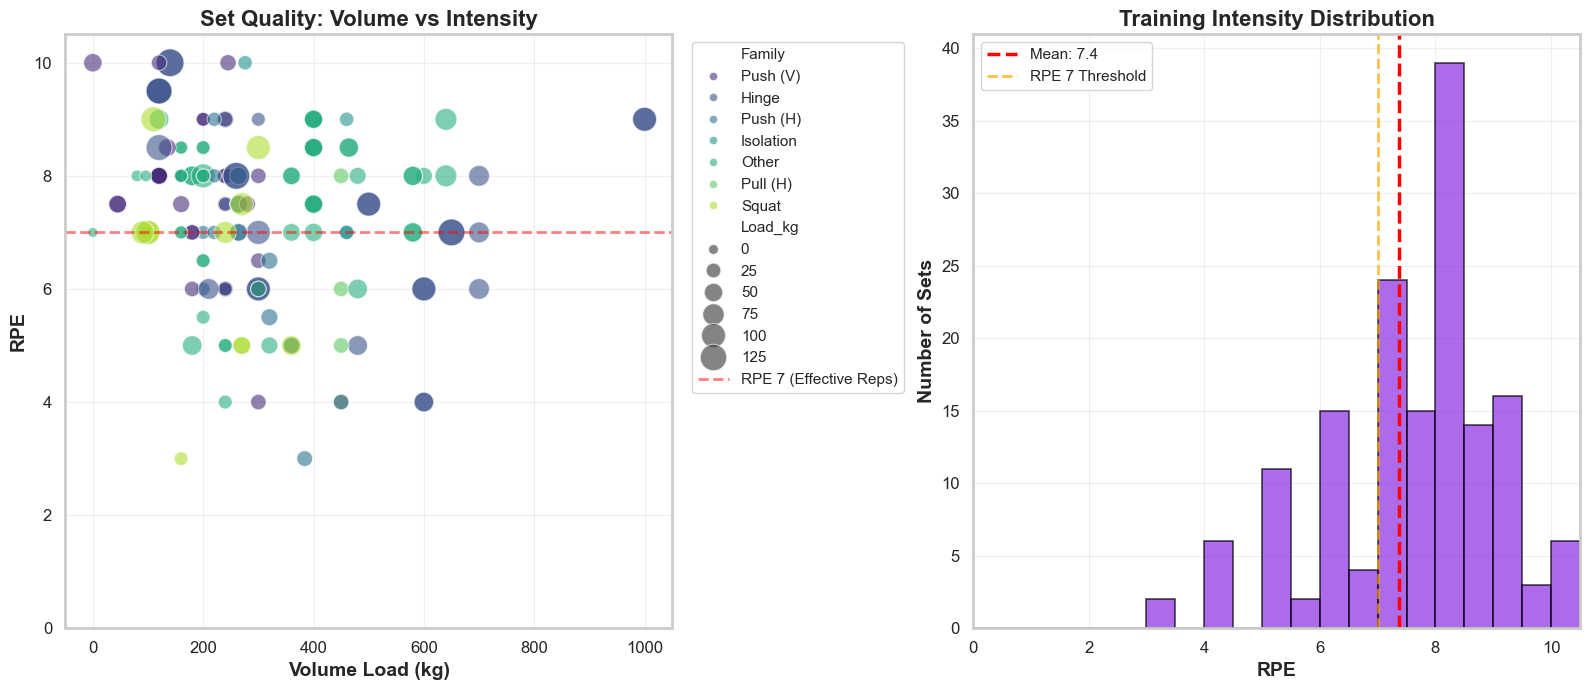


Effective sets (RPE >= 7): 117/157 (75%)


In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# 1. Set Quality Scatter: Volume vs RPE by Family
scatter = sns.scatterplot(data=df, x="Volume_Load", y="Intensity_RPE", 
                          hue="Family", size="Load_kg", sizes=(50, 400), 
                          alpha=0.6, ax=ax1, palette="viridis")
ax1.axhline(y=7, color="red", linestyle="--", linewidth=2, alpha=0.5, label="RPE 7 (Effective Reps)")
ax1.set_xlabel("Volume Load (kg)")
ax1.set_ylabel("RPE")
ax1.set_title("Set Quality: Volume vs Intensity")
ax1.set_ylim(0, 10.5)
ax1.legend(bbox_to_anchor=(1.02, 1), loc="upper left")

# 2. RPE Distribution Histogram
ax2.hist(df["Intensity_RPE"].dropna(), bins=np.arange(0, 11, 0.5), 
         color="#8a2be2", edgecolor="black", linewidth=1.2, alpha=0.7)
ax2.axvline(x=df["Intensity_RPE"].mean(), color="red", linestyle="--", 
            linewidth=2.5, label=f"Mean: {df['Intensity_RPE'].mean():.1f}")
ax2.axvline(x=7, color="orange", linestyle="--", linewidth=2, alpha=0.7, label="RPE 7 Threshold")
ax2.set_xlabel("RPE")
ax2.set_ylabel("Number of Sets")
ax2.set_title("Training Intensity Distribution")
ax2.set_xlim(0, 10.5)
ax2.legend()

plt.tight_layout()
plt.show()

# Summary stats
high_effort = (df["Intensity_RPE"] >= 7).sum()
total_sets = len(df)
print(f"\nEffective sets (RPE >= 7): {high_effort}/{total_sets} ({high_effort/total_sets*100:.0f}%)")

## Training Style Analysis

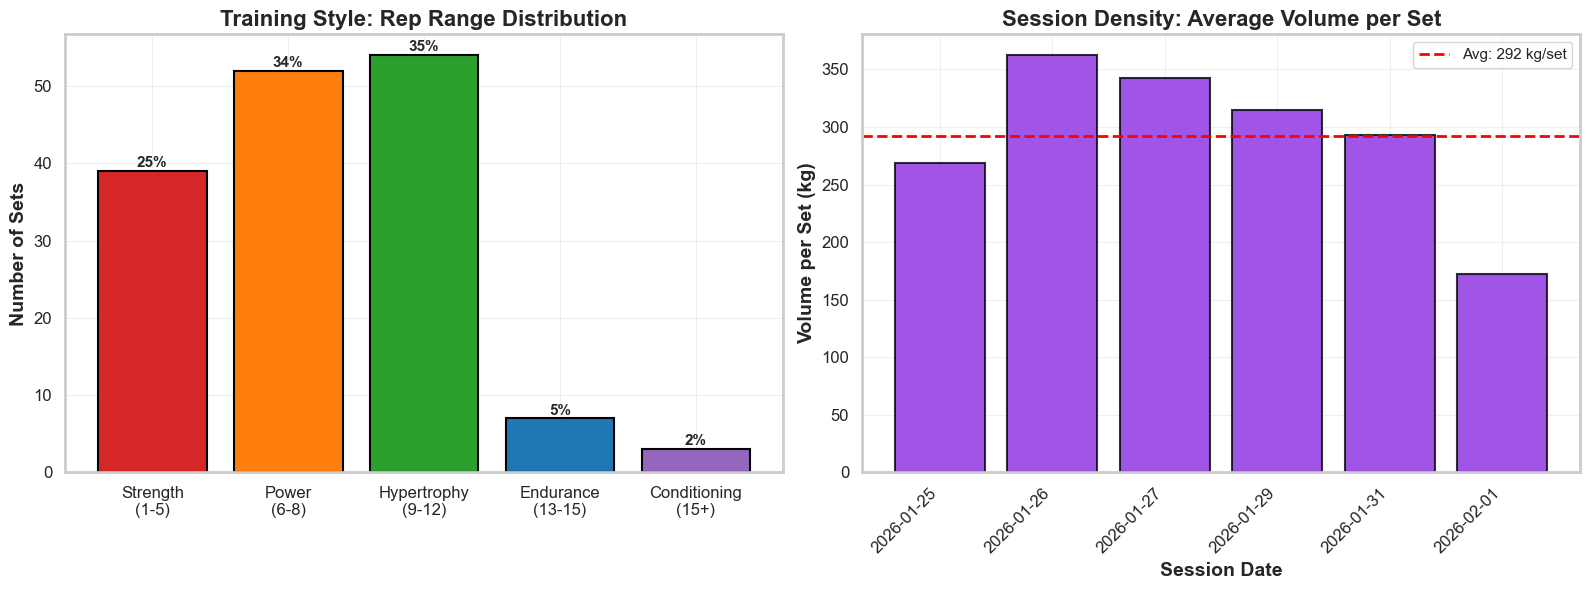


Dominant training style: Hypertrophy (9-12) (54/155 sets, 35%)


In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 1. Rep Range Distribution - Training Style
rep_bins = [0, 5, 8, 12, 15, 100]
rep_labels = ["Strength\n(1-5)", "Power\n(6-8)", "Hypertrophy\n(9-12)", "Endurance\n(13-15)", "Conditioning\n(15+)"]
df["Rep_Zone"] = pd.cut(df["Reps"], bins=rep_bins, labels=rep_labels, right=True)

zone_counts = df["Rep_Zone"].value_counts().reindex(rep_labels)
colors = ["#d62728", "#ff7f0e", "#2ca02c", "#1f77b4", "#9467bd"]
bars = ax1.bar(zone_counts.index, zone_counts.values, color=colors, edgecolor="black", linewidth=1.5)
ax1.set_ylabel("Number of Sets")
ax1.set_title("Training Style: Rep Range Distribution")

# Add percentage labels
total = zone_counts.sum()
for bar, count in zip(bars, zone_counts.values):
    if count > 0:
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f"{count/total*100:.0f}%", ha="center", fontweight="bold", fontsize=11)

# 2. Volume per Set (Session Efficiency)
session_efficiency = df.groupby("Date").agg({
    "Volume_Load": ["sum", "count"]
}).droplevel(0, axis=1)
session_efficiency.columns = ["Total_Volume", "Set_Count"]
session_efficiency["Vol_Per_Set"] = session_efficiency["Total_Volume"] / session_efficiency["Set_Count"]

ax2.bar(range(len(session_efficiency)), session_efficiency["Vol_Per_Set"], 
        color="#8a2be2", edgecolor="black", linewidth=1.5, alpha=0.8)
ax2.axhline(y=session_efficiency["Vol_Per_Set"].mean(), color="red", linestyle="--", 
            linewidth=2, label=f"Avg: {session_efficiency['Vol_Per_Set'].mean():.0f} kg/set")
ax2.set_xticks(range(len(session_efficiency)))
ax2.set_xticklabels([str(d) for d in session_efficiency.index], rotation=45, ha="right")
ax2.set_ylabel("Volume per Set (kg)")
ax2.set_xlabel("Session Date")
ax2.set_title("Session Density: Average Volume per Set")
ax2.legend()

plt.tight_layout()
plt.show()

# Training style summary
dominant_zone = zone_counts.idxmax()
print(f"\nDominant training style: {dominant_zone.replace(chr(10), ' ')} ({zone_counts.max()}/{total} sets, {zone_counts.max()/total*100:.0f}%)")

## 2026 Milestone Progress

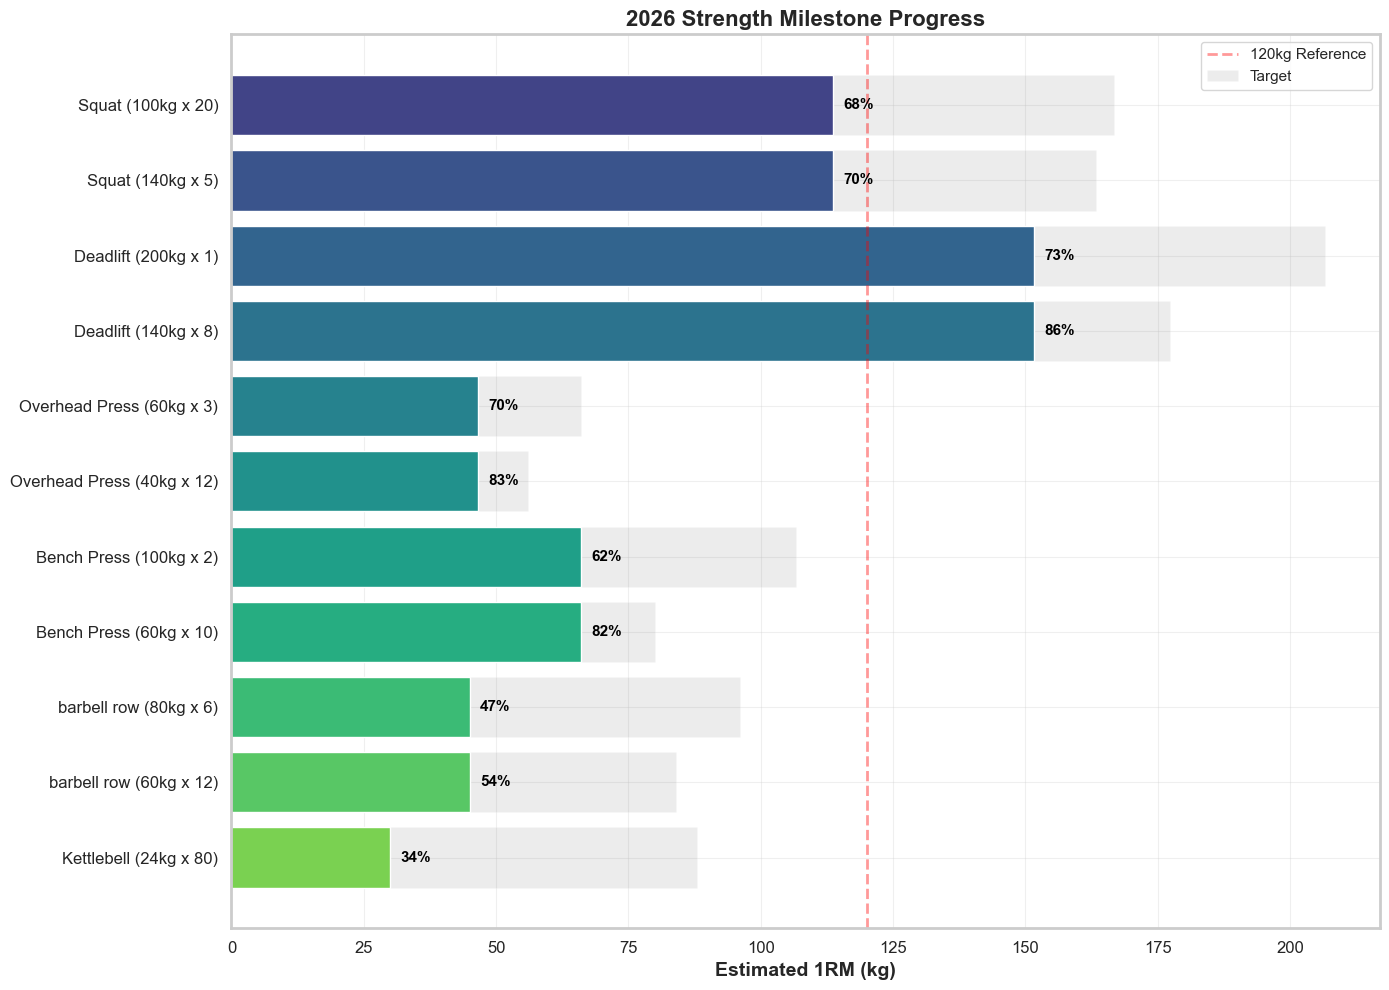


=== Milestone Summary ===
Squat (100kg x 20)                              68% (PR 0d ago)
Squat (140kg x 5)                               70% (PR 0d ago)
Deadlift (200kg x 1)                            73% (PR 5d ago)
Deadlift (140kg x 8)                            86% (PR 5d ago)
Overhead Press (60kg x 3)                       70% (PR 5d ago)
Overhead Press (40kg x 12)                      83% (PR 5d ago)
Bench Press (100kg x 2)                         62% (PR 0d ago)
Bench Press (60kg x 10)                         82% (PR 0d ago)
barbell row (80kg x 6)                          47% (PR 5d ago)
barbell row (60kg x 12)                         54% (PR 5d ago)
Kettlebell (24kg x 80)                          34% (PR 5d ago)


In [13]:
def calculate_milestone_progress(df):
    """Calculate progress toward each milestone goal."""
    today = pd.Timestamp(datetime.now())
    plot_data = []
    
    for move, targets in MILESTONES.items():
        # Find matching movements (case-insensitive partial match)
        family_df = df[df["Movement"].str.contains(move, case=False, na=False)]
        
        if not family_df.empty:
            best_row = family_df.loc[family_df["e1RM"].idxmax()]
            current_e1rm = best_row["e1RM"]
            days_ago = (today - best_row["Timestamp"]).days
        else:
            current_e1rm, days_ago = 0, 365
        
        for weight, reps in targets:
            target_e1rm = weight * (1 + reps / 30)
            plot_data.append({
                "Goal": f"{move} ({weight}kg x {reps})",
                "Current": current_e1rm,
                "Target": target_e1rm,
                "Days Ago": days_ago,
                "Pct": (current_e1rm / target_e1rm * 100) if target_e1rm > 0 else 0
            })
    
    return pd.DataFrame(plot_data)

m_df = calculate_milestone_progress(df)

fig, ax = plt.subplots(figsize=(14, 10))

# Background: target bars
ax.barh(m_df["Goal"], m_df["Target"], color="grey", alpha=0.15, label="Target")

# Foreground: current progress with color gradient
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(m_df)))
ax.barh(m_df["Goal"], m_df["Current"], color=colors)

# Annotations
for i, row in m_df.iterrows():
    color = "green" if row["Pct"] >= 100 else "black"
    ax.text(row["Current"] + 2, i, f"{row['Pct']:.0f}%", va="center", fontweight="bold", color=color, fontsize=11)

ax.axvline(x=120, color="red", linestyle="--", alpha=0.4, linewidth=2, label="120kg Reference")
ax.set_xlabel("Estimated 1RM (kg)")
ax.set_title("2026 Strength Milestone Progress")
ax.legend(loc="upper right")
ax.invert_yaxis()  # Top-to-bottom order

plt.tight_layout()
plt.show()

# Summary table
print("\n=== Milestone Summary ===")
for _, row in m_df.iterrows():
    status = "ACHIEVED" if row["Pct"] >= 100 else f"{row['Pct']:.0f}%"
    print(f"{row['Goal']:40} {status:>10} (PR {row['Days Ago']}d ago)")

## Relative Strength & Lift Ratios

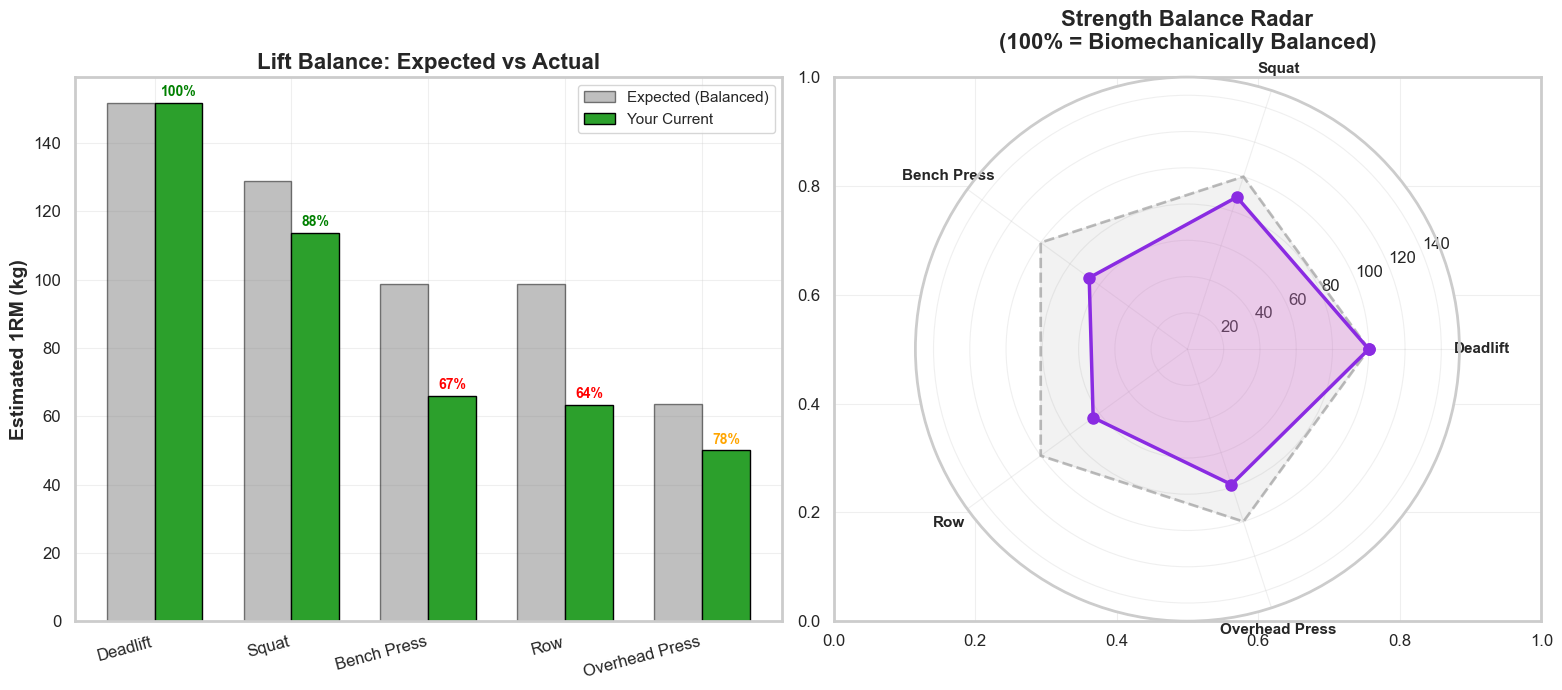


=== Strength Balance Analysis ===
Deadlift              151.7kg /  151.7kg expected =   100% [BALANCED]
Squat                 113.7kg /  128.9kg expected =    88% [BALANCED]
Bench Press            66.0kg /   98.6kg expected =    67% [WEAK]
Row                    63.3kg /   98.6kg expected =    64% [WEAK]
Overhead Press         50.0kg /   63.7kg expected =    78% [WEAK]


In [14]:
# Biomechanical strength ratio benchmarks (relative to Deadlift = 1.0)
# These are approximate ratios for balanced strength
RATIO_BENCHMARKS = {
    "Deadlift": 1.0,
    "Squat": 0.85,        # Squat ~85% of deadlift
    "Bench Press": 0.65,  # Bench ~65% of deadlift  
    "Row": 0.65,          # Row should roughly match bench
    "Overhead Press": 0.42  # OHP ~65% of bench, ~42% of deadlift
}

def get_best_e1rm(df, search_term):
    """Get best e1RM for a movement pattern."""
    matches = df[df["Movement"].str.contains(search_term, case=False, na=False)]
    return matches["e1RM"].max() if not matches.empty else 0

# Calculate current maxes
current_maxes = {
    "Deadlift": get_best_e1rm(df, "Deadlift"),
    "Squat": get_best_e1rm(df, "Squat"),
    "Bench Press": get_best_e1rm(df, "Bench|DB Press"),
    "Row": get_best_e1rm(df, "Row"),
    "Overhead Press": get_best_e1rm(df, "Overhead Press|OHP")
}

# Use deadlift as reference (or strongest lift if no deadlift)
reference_lift = current_maxes["Deadlift"] if current_maxes["Deadlift"] > 0 else max(current_maxes.values())

if reference_lift > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # 1. Actual vs Expected Ratios (radar-style bar comparison)
    lifts = list(RATIO_BENCHMARKS.keys())
    expected = [RATIO_BENCHMARKS[l] * reference_lift for l in lifts]
    actual = [current_maxes[l] for l in lifts]
    
    x = np.arange(len(lifts))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, expected, width, label="Expected (Balanced)", color="grey", alpha=0.5, edgecolor="black")
    bars2 = ax1.bar(x + width/2, actual, width, label="Your Current", color="#2ca02c", edgecolor="black")
    
    ax1.set_ylabel("Estimated 1RM (kg)")
    ax1.set_title("Lift Balance: Expected vs Actual")
    ax1.set_xticks(x)
    ax1.set_xticklabels(lifts, rotation=15, ha="right")
    ax1.legend()
    
    # Add ratio annotations
    for i, (exp, act) in enumerate(zip(expected, actual)):
        if exp > 0:
            ratio = act / exp * 100
            color = "green" if 85 <= ratio <= 115 else ("orange" if 70 <= ratio <= 130 else "red")
            ax1.text(i + width/2, act + 2, f"{ratio:.0f}%", ha="center", fontweight="bold", color=color, fontsize=10)
    
    # 2. Strength Ratio Spider/Polar Chart
    ax2 = plt.subplot(122, projection="polar")
    
    # Normalize to percentage of expected
    ratios = [current_maxes[l] / (RATIO_BENCHMARKS[l] * reference_lift) * 100 
              if RATIO_BENCHMARKS[l] * reference_lift > 0 else 0 for l in lifts]
    
    angles = np.linspace(0, 2 * np.pi, len(lifts), endpoint=False).tolist()
    ratios_closed = ratios + ratios[:1]
    angles_closed = angles + angles[:1]
    
    # 100% reference circle
    ax2.plot(angles_closed, [100] * len(angles_closed), color="grey", linestyle="--", linewidth=2, alpha=0.5, label="Balanced (100%)")
    ax2.fill(angles_closed, [100] * len(angles_closed), color="grey", alpha=0.1)
    
    # Actual ratios
    ax2.plot(angles_closed, ratios_closed, color="#8a2be2", linewidth=2.5, marker="o", markersize=8)
    ax2.fill(angles_closed, ratios_closed, color="#da70d6", alpha=0.3)
    
    ax2.set_xticks(angles)
    ax2.set_xticklabels(lifts, fontsize=11, fontweight="bold")
    ax2.set_ylim(0, max(150, max(ratios) + 20))
    ax2.set_title("Strength Balance Radar\n(100% = Biomechanically Balanced)", pad=20)
    
    plt.tight_layout()
    plt.show()
    
    # Imbalance analysis
    print("\n=== Strength Balance Analysis ===")
    for lift in lifts:
        expected_val = RATIO_BENCHMARKS[lift] * reference_lift
        actual_val = current_maxes[lift]
        if expected_val > 0:
            ratio = actual_val / expected_val * 100
            status = "BALANCED" if 85 <= ratio <= 115 else ("WEAK" if ratio < 85 else "STRONG")
            print(f"{lift:20} {actual_val:6.1f}kg / {expected_val:6.1f}kg expected = {ratio:5.0f}% [{status}]")
else:
    print("Need deadlift or other compound lift data for ratio analysis.")

## PR Timeline & Records

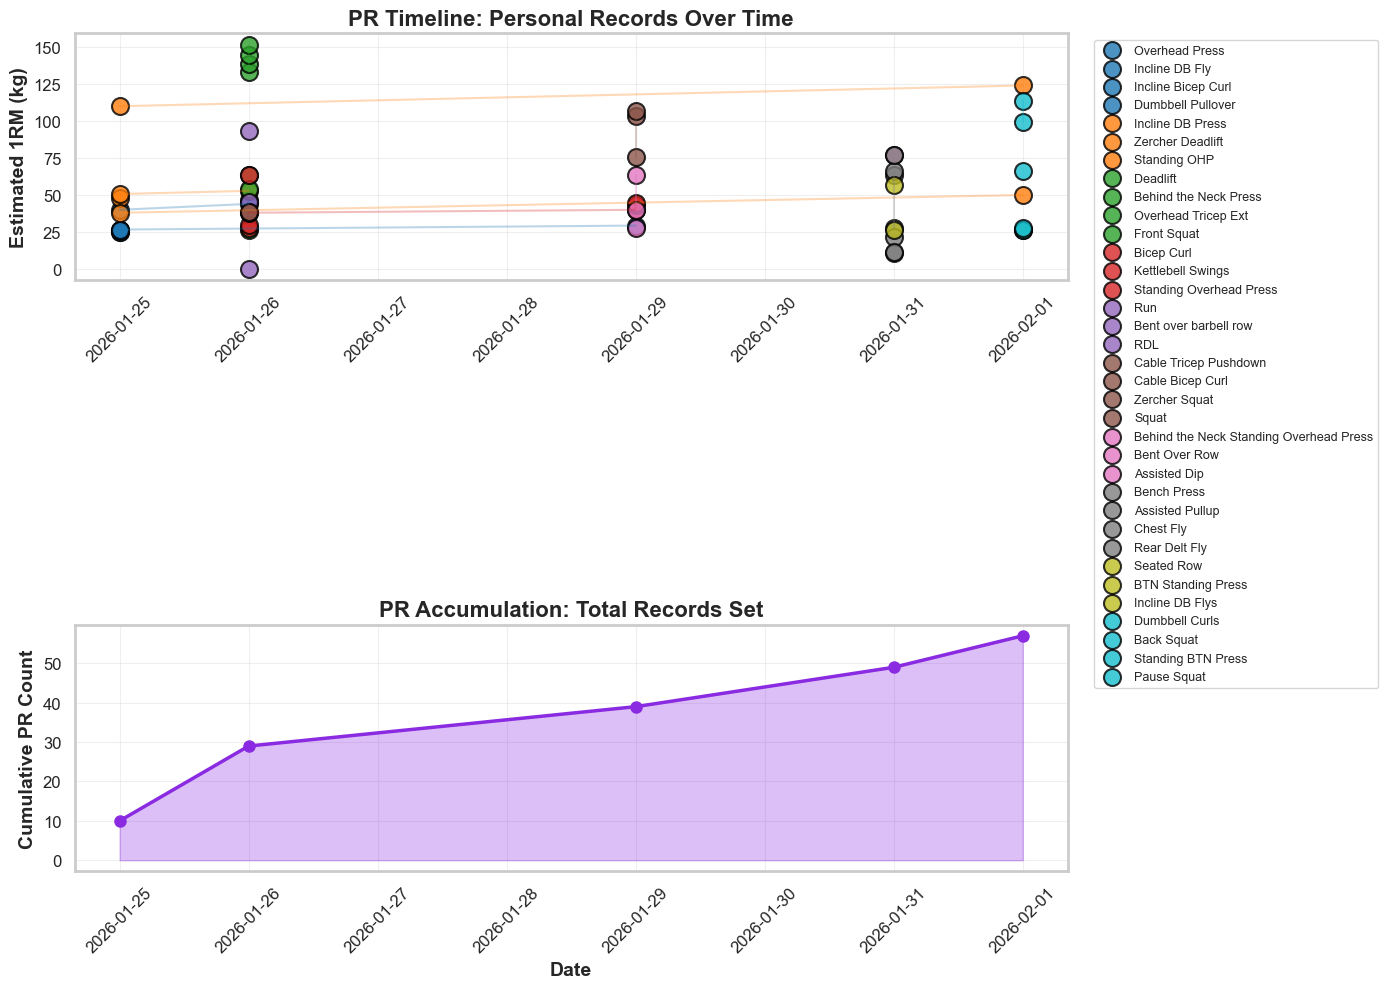


=== Current Personal Records ===
Deadlift                        133.3kg  (100kg x 10)  [2026-01-26]
Zercher Deadlift                124.0kg  (120kg x 1)  [2026-02-01]
Zercher Squat                   103.3kg  (100kg x 1)  [2026-01-29]
Back Squat                       99.0kg  (90kg x 3)  [2026-02-01]
RDL                              93.3kg  (70kg x 10)  [2026-01-26]
Assisted Pullup                  77.3kg  (58kg x 10)  [2026-01-31]
Assisted Dip                     77.3kg  (58kg x 10)  [2026-01-31]
Squat                            76.0kg  (60kg x 8)  [2026-01-29]
Pause Squat                      66.0kg  (60kg x 3)  [2026-02-01]
Bench Press                      66.0kg  (60kg x 3)  [2026-01-31]
Bicep Curl                       63.3kg  (50kg x 8)  [2026-01-26]
Overhead Tricep Ext              63.3kg  (50kg x 8)  [2026-01-26]
Seated Row                       57.0kg  (45kg x 8)  [2026-01-31]
Front Squat                      54.0kg  (45kg x 6)  [2026-01-26]
Incline DB Press                 52

In [15]:
# Find PR (personal record) for each movement over time
def calculate_prs(df):
    """Track cumulative PRs for each movement."""
    pr_records = []
    movement_prs = {}  # Track current PR for each movement
    
    for _, row in df.sort_values("Timestamp").iterrows():
        move = row["Movement"]
        e1rm = row["e1RM"]
        date = row["Date"]
        
        if move not in movement_prs or e1rm > movement_prs[move]:
            movement_prs[move] = e1rm
            pr_records.append({
                "Date": date,
                "Movement": move,
                "e1RM": e1rm,
                "Load_kg": row["Load_kg"],
                "Reps": row["Reps"]
            })
    
    return pd.DataFrame(pr_records)

pr_df = calculate_prs(df)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# 1. PR Timeline - scatter plot of all PRs
movements = pr_df["Movement"].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(movements)))
move_colors = dict(zip(movements, colors))

for move in movements:
    move_prs = pr_df[pr_df["Movement"] == move]
    ax1.scatter(move_prs["Date"], move_prs["e1RM"], 
                label=move, s=150, alpha=0.8, edgecolor="black", linewidth=1.5,
                c=[move_colors[move]])
    # Connect PRs with lines
    if len(move_prs) > 1:
        ax1.plot(move_prs["Date"], move_prs["e1RM"], 
                 alpha=0.3, linewidth=1.5, c=move_colors[move])

ax1.set_ylabel("Estimated 1RM (kg)")
ax1.set_title("PR Timeline: Personal Records Over Time")
ax1.legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=9)
ax1.tick_params(axis="x", rotation=45)

# 2. PR Count by Date - cumulative PRs
pr_counts = pr_df.groupby("Date").size().cumsum()
ax2.fill_between(pr_counts.index, pr_counts.values, alpha=0.3, color="#8a2be2")
ax2.plot(pr_counts.index, pr_counts.values, color="#8a2be2", linewidth=2.5, marker="o", markersize=8)
ax2.set_ylabel("Cumulative PR Count")
ax2.set_xlabel("Date")
ax2.set_title("PR Accumulation: Total Records Set")
ax2.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

# PR Table
print("\n=== Current Personal Records ===")
current_prs = pr_df.sort_values("Date").drop_duplicates("Movement", keep="last").sort_values("e1RM", ascending=False)
for _, row in current_prs.iterrows():
    print(f"{row['Movement']:30} {row['e1RM']:6.1f}kg  ({row['Load_kg']}kg x {row['Reps']})  [{row['Date']}]")